In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd

import numpy as np

import math
import seaborn as sns
import os
from collections import defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
from joblib import Parallel, delayed
from multiprocessing import Lock

# Create a lock
lock = Lock()

In [3]:
class Empty:
    pass
args = Empty()
args.dim = 5
args.num_y = 30
args.beta = 5
args.T = 1000
args.K = 10
args.dim_x = 2
# args.alpha = math.sqrt(args.T/args.d)
args.clip = 1.0
args.lr = 2e-3
args.max_optimize_iter = 50
args.sample_batch_size = 5
# args.optimize_batch_size = 512
# args.adapt = 0.9
eps = 1e-5

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [4]:
def eval_pair(scoref, x, y_pair, gen):
    # x    : batch_size x dim_x
    # y_pair: batch_size x (index 1, index 2)
    # output: batch_size  x (winner index, loser index)
    device = y_pair.device
    p = torch.sigmoid(scoref(x, y_pair[:,0]) - scoref(x, y_pair[:,1]))
    outcome = torch.rand(y_pair.size()[0],device=device, generator=gen) < p
    y_pair[outcome == 0] = y_pair[outcome == 0][:, [1, 0]]
    return y_pair

class FeatureModel(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.ln = nn.Linear(args.num_y + args.dim_x, args.dim)
        self.ln.requires_grad = False
        self.num_y = args.num_y

    def forward(self, x, y):
        with torch.no_grad():
            feature = torch.cat((x, F.one_hot(y, num_classes=self.num_y)), dim=-1)
            feature = self.ln(feature)
            feature = torch.tanh(feature)
        return feature 

class PolicyModel(nn.Module):
    def __init__(self, pi_theta_ref, feature_model, args):
        super().__init__()
        self.args = args
        self.feature = feature_model
        self.pi_theta_ref = pi_theta_ref
        self.theta = nn.Parameter(pi_theta_ref.clone())
        self.beta = args.beta

    def forward(self, x):
        return x

    def policy(self, x):
        # x: batch_size x dim_x
        B = x.size()[0]
        device = x.device
        feature = self.feature(x.repeat(1, self.args.num_y).reshape(B*self.args.num_y, self.args.dim_x),
                              torch.arange(self.args.num_y, device=device).repeat(B))
        logit = torch.sum(feature*self.theta, dim=1)
        logit = logit.reshape(B, self.args.num_y)
        policy = torch.exp(logit)
        policy = policy/policy.sum(dim=1,keepdims=True)
        return policy
                
    def clamp(self, min=-1.0, max=1.0):
        with torch.no_grad():
            # self.theta.data -= self.theta.data.mean()
            self.theta.data.clamp_(self.pi_theta_ref+min, self.pi_theta_ref+max)
    
    def dpo_loss(self, winner_feature, loser_feature):
        # normalized negative likelihood
        # x:      batch_size x dim_x
        # y_cmp : batch_size x (winner index, loser index)
        # winner_feature = self.feature(x, y_cmp[:,0])
        # loser_feature = self.feature(x, y_cmp[:,1])
        diff_reward = self.beta*torch.sum((winner_feature - loser_feature)*(self.theta-self.pi_theta_ref), dim=1)
        p = torch.sigmoid(diff_reward)
        return -torch.mean(torch.log(p+eps))

In [5]:
def train(args, optimizer, pi_ref, policy_model, data_x, winner_feature, loser_feature, alpha = 0.0):
    n_data = data_x.size()[0]
    # with torch.no_grad():
        # pi_ref = policy_ref_model.policy(data_x)
        # winner_feature = policy_model.feature(data_x, data_y[:,0])
        # loser_feature = policy_model.feature(data_x, data_y[:,1])

    # sample_size = min(args.sample_size, data.size()[0])
    for t in range(args.max_optimize_iter):
        loss = policy_model.dpo_loss(winner_feature, loser_feature)
        pi = policy_model.policy(data_x)
        rb_loss = torch.mean(torch.sum(pi_ref * torch.log(pi), dim=1))
        loss += rb_loss*alpha*args.beta/n_data

        loss.backward()
        # torch.nn.utils.clip_grad_norm_(policy_model.parameters(), args.clip)
        optimizer.step()
        optimizer.zero_grad()
        policy_model.clamp()

In [6]:
# Function to write to the log file
def write_to_log(df, lock, file_path):
    with lock:
        # Ensure thread-safe appending to the log file
        if not os.path.exists(file_path):
            # Write the header if the file doesn't exist
            df.to_csv(file_path, mode='w', header=True, index=False)
        else:
            # Append without writing the header
            df.to_csv(file_path, mode='a', header=False, index=False)

In [7]:
# regret_list_RB = {}
# for k in range(args.K):   
def worker(args, seed, alpha):
    regret_list_RB = {}
    gen = torch.Generator(device=device)
    gen.manual_seed(seed)

    feature_model = FeatureModel(args)
    feature_model = feature_model.to(device)

    pi_theta_ref = torch.rand(args.dim, generator=gen, device=device)
    # pi_theta_ref = pi_theta_ref/pi_theta_ref.sum()
    
    reward_star = torch.rand(args.dim, generator=gen, device=device)

    policy_star_model = PolicyModel(pi_theta_ref+reward_star/args.beta, feature_model, args).to(device)
    policy_ref_model = PolicyModel(pi_theta_ref, feature_model, args).to(device)

    scoref = lambda x, y: torch.sum(feature_model(x, y)*reward_star, dim=1)
    # rewardf = lambda x, pi: (pi*reward_star).sum() - args.beta*(pi*(torch.log(pi) - torch.log(pi_theta_ref))).sum()
    new_df_list = []
        
    norm_pi = pi_theta_ref.clone()
    regret_list_RB[alpha] = [0] * args.T
    policy_model = PolicyModel(pi_theta_ref, feature_model, args).to(device)
    # optimizer = optim.Adam(policy_model.parameters(), lr=args.lr,betas=(0.9, 0.95))
    # optimizer = optim.AdamW(policy_model.parameters(), lr=args.lr,betas=(0.9, 0.95), weight_decay=1e-2)
    optimizer = optim.SGD(policy_model.parameters(), lr=args.lr, momentum=0.9)
    regret = 0.0
    for t in tqdm(range(args.T)):
        with torch.no_grad():
            x = torch.randn(100, args.dim_x, generator=gen, device=device)
            pi_star = policy_star_model.policy(x)
            pi = policy_model.policy(x)
        regret += args.beta*torch.mean(torch.sum(pi*(torch.log(pi)-torch.log(pi_star)),dim=1))
        regret_list_RB[alpha][t] = regret.item()

        with torch.no_grad():
            x = torch.randn(args.sample_batch_size, args.dim_x, generator=gen, device=device)
            pi = policy_model.policy(x)
            y_pair = torch.multinomial(pi, 2, True, generator=gen).view(args.sample_batch_size, 2)
            y_cmp = eval_pair(scoref, x, y_pair, gen)
            if t == 0:
                data_x, data_y = x, y_cmp
                winner_feature = policy_model.feature(x, y_cmp[:,0])
                loser_feature = policy_model.feature(x, y_cmp[:,1])
                pi_ref = policy_ref_model.policy(x)
            else:
                data_x = torch.cat((data_x, x), dim=0)
                # data_y = torch.cat((data_y, y_cmp), dim=0)
                new_winner_feature = policy_model.feature(x, y_cmp[:,0])
                new_loser_feature = policy_model.feature(x, y_cmp[:,1])
                new_pi_ref = policy_ref_model.policy(x)
                winner_feature = torch.cat((winner_feature, new_winner_feature), dim=0)
                loser_feature = torch.cat((loser_feature, new_loser_feature), dim=0)
                pi_ref = torch.cat((pi_ref, new_pi_ref), dim=0)            
        # with torch.no_grad():
        #     norm_pi = args.adapt*norm_pi + (1-args.adapt)*pi

        # optimize 
        train(args, optimizer, pi_ref, policy_model, data_x, winner_feature, loser_feature, alpha)
    
    new_df = pd.DataFrame({'regret': regret_list_RB[alpha], 'iter': range(args.T)})
    new_df['seed'] = seed
    new_df['alpha'] = alpha
    new_df_list.append(new_df)
    df = pd.concat(new_df_list)
    write_to_log(df, lock, "log_linear.csv")
    return 

In [8]:
if os.path.exists("log_linear.csv"):
    os.remove('log_linear.csv')

In [9]:
alpha_list = [0.0, 1.0]
Parallel(n_jobs=2, prefer="threads")(
    delayed(worker)(args, k, alpha) 
    for k in range(10) 
    for alpha in alpha_list
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

C:\Users\NoctiZen\AppData\Local\Temp\ipykernel_2776\3930199930.py:17: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  gfg = sns.lineplot(x="iter", y="regret", hue="alpha", style="alpha",


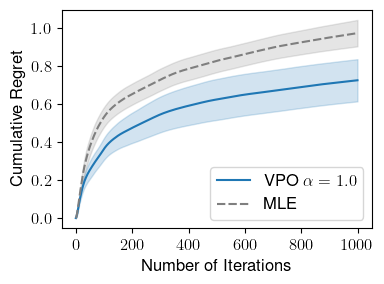

In [11]:
df = pd.read_csv("log_linear.csv")
alpha_list = [0.0, 1.0]
tmpdf = df[df['alpha'].isin(alpha_list)]
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 12,
    "figure.figsize": (4,3)
})
# tweak plotting order
tmpdf['alpha'] = -tmpdf['alpha']
palette = sns.color_palette()
gfg = sns.lineplot(x="iter", y="regret", hue="alpha", style="alpha",
             data=tmpdf, palette=['tab:blue','tab:grey','tab:green'],errorbar="se")
# gfg = sns.lineplot(x="iter", y="regret", hue="alpha", style="alpha",
#              data=tmpdf)
gfg.set_xlabel('Number of Iterations')
gfg.set_ylabel('Cumulative Regret')
# gfg.set_ylim([0,80])
# gfg.set_xlim([0,200])
lgd = gfg.legend()
# gfg.legend().set_title(None)
# replace labels
new_labels = [f'VPO $\\alpha={alpha}$' if alpha != 0.0 else 'MLE' for alpha in alpha_list[::-1]]
for t, l in zip(lgd.texts, new_labels):
    t.set_text(l)
# lgd.set_loc(2)
plt.tight_layout()
plt.savefig('linear.pdf')